# Tarea 1 - Series de tiempo MAT417

Librerías

In [23]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.ticker as ticker
import numpy as np

Scraping de los datos (Con la ayuda de la gente de  [Real time prices](https://oldschool.runescape.wiki/w/RuneScape:Real-time_Prices))

In [7]:
# Define the API endpoint
#url = 'https://prices.runescape.wiki/api/v1/osrs/24' #Este es para tomar el precio medio en 24 horas para atras
url = 'https://prices.runescape.wiki/api/v1/osrs/timeseries?timestep=24h&id=13190'
# Specify the item ID and timestep
item_id = '13190'  # Replace with the actual item ID
timestep = '24h'  # Choose from "5m", "1h", "6h", "24h"

# Construct the full URL with query parameters
#url = f"{base_url}?id={item_id}&timestep={timestep}"

headers = {
    'User-Agent':  "Bond Time Series - @Larva on Discord - ID:198969709272629249",
    'From': 'Eric.zepeda.14@sansano.usm.cl',  # This is another valid field

}
data = {}
# Make a GET request to the API
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Extract relevant data (for example, prices)
    prices = data.get('data', {})

else:
    print(f"Failed to retrieve data: {response.status_code}")

Conversión  a Dataframe

In [5]:
# Convertir a DataFrame
df = pd.DataFrame(prices)

# Convertir el timestamp a formato de fecha
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

# Opcional: Eliminar la columna de timestamp si no es necesaria
df.drop(columns='timestamp', inplace=True)

# Mostrar el DataFrame
df.head()

,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,date
0,8633364,8634308,10079,4273,2023-08-29
1,8567069,8572491,11147,3855,2023-08-30
2,8417604,8442176,11549,4022,2023-08-31
3,8256880,8230461,11650,3505,2023-09-01
4,8256695,8238346,12097,4456,2023-09-02


In [3]:
df.columns

Index(['avgHighPrice', 'avgLowPrice', 'highPriceVolume', 'lowPriceVolume',
       'date'],
      dtype='object')

In [9]:
df["price"] = (df['avgHighPrice']+df['avgLowPrice'])/2

Primera visualización de la serie

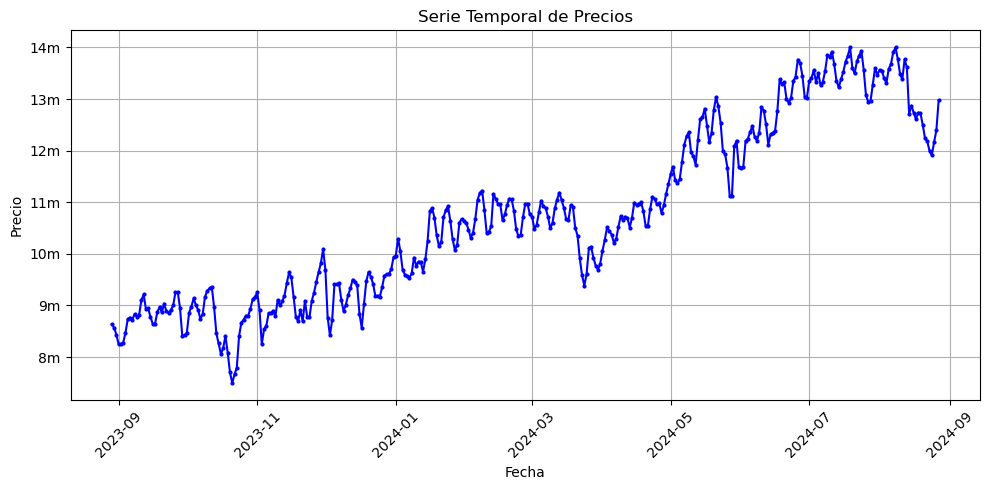

In [12]:
# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['price'], marker='o', linestyle='-', color='b', markersize=2)

# Configurar etiquetas y título
plt.title('Serie Temporal de Precios')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid()
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para mejor legibilidad
# Formatear los valores del eje Y en millones
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x/1e6:.0f}m"))
# Mostrar la gráfica
plt.tight_layout()  # Ajustar el layout para que no se solapen los elementos
plt.show()

Filtro de Hodrick Prescott

In [41]:
def crear_matriz_A(n):
    # Crear una matriz de ceros de tamaño n x n
    matriz = np.zeros((n-2, n))
    
    # Llenar la diagonal principal con 1
    np.fill_diagonal(matriz, 1)
    
    # Llenar la diagonal superior con -2
    np.fill_diagonal(matriz[:, 1:n-1], -2)
    
    # Llenar la diagonal superior a la anterior con 1
    np.fill_diagonal(matriz[:, 2:], 1)
    
    return matriz


In [42]:
Y = df["price"].to_numpy()
n = Y.shape[0]
A = crear_matriz_A(n)
ATA = np.dot(A.T,A)
nn = np.dot(A.T,A).shape[0]
In =  np.eye(nn)

In [43]:
lamda = 129600
S = np.dot(np.linalg.inv(In+lamda*ATA),Y)
C = Y-S

In [44]:
df["S"] = S
df["C"] = C

Con esto veamos como queda el filtro

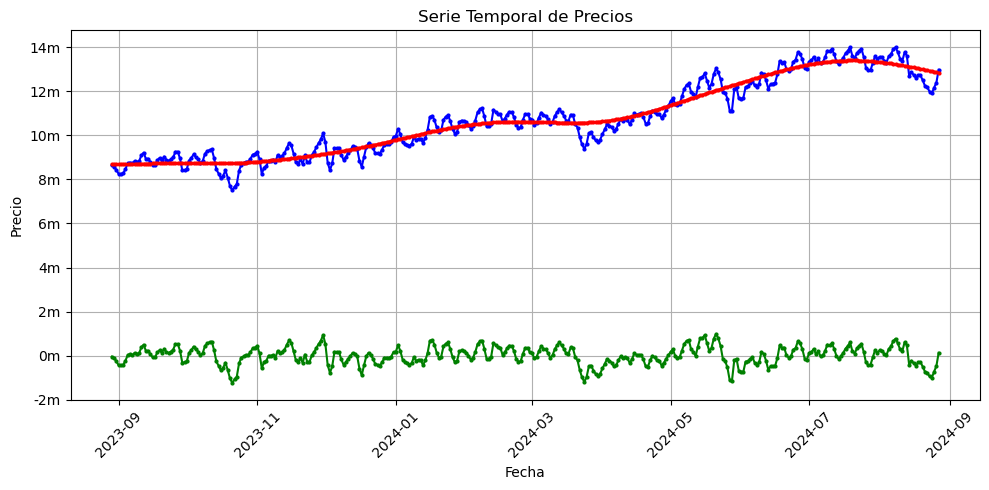

In [45]:
# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['price'], marker='o', linestyle='-', color='b', markersize=2)
plt.plot(df['date'], df['S'], marker='o', linestyle='-', color='r', markersize=2)
plt.plot(df['date'], df['C'], marker='o', linestyle='-', color='g', markersize=2)

# Configurar etiquetas y título
plt.title('Serie Temporal de Precios')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid()
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para mejor legibilidad
# Formatear los valores del eje Y en millones
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x/1e6:.0f}m"))
# Mostrar la gráfica
plt.tight_layout()  # Ajustar el layout para que no se solapen los elementos
plt.show()

Comparemos con lo que da statsmodels

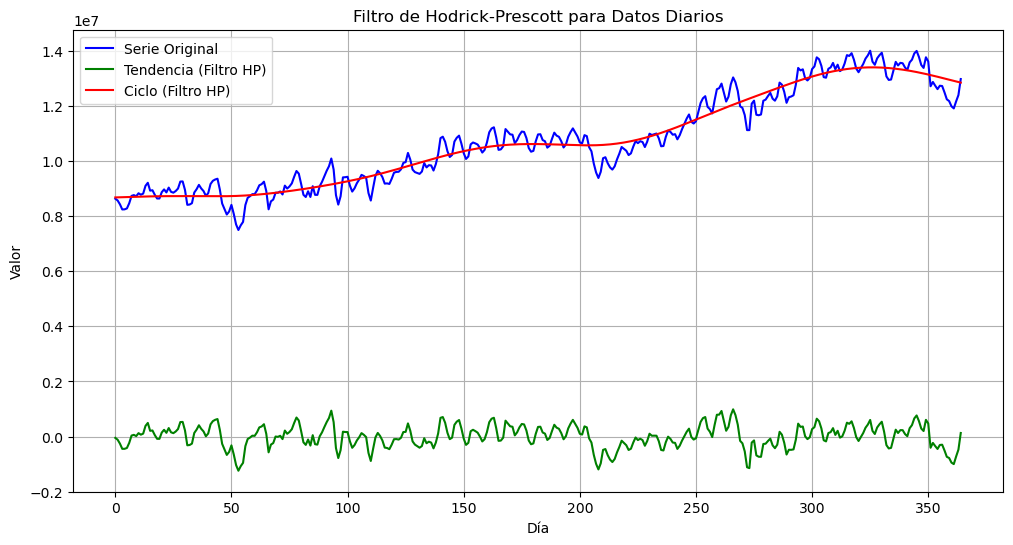

In [39]:
from statsmodels.tsa.filters.hp_filter import hpfilter


df['trend'], df['cycle'] = hpfilter(df['price'], lamb=lamda)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df['price'], label='Serie Original', color='blue')
plt.plot(df['trend'], label='Tendencia (Filtro HP)', color='green')
plt.plot(df['cycle'], label='Ciclo (Filtro HP)', color='red')
plt.title('Filtro de Hodrick-Prescott para Datos Diarios')
plt.xlabel('Día')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

Victoria!